In [1]:
import salabim as sim
import sqlite3 as sql
import pandas as pd
import random
import arrow
from time import time
pd.set_option('display.max_columns', None)

In [2]:
def Normal(a, b):
    return sim.Bounded(sim.Normal(a, b), lowerbound=0).sample()

def Uniform(a, b):
    return sim.Uniform(a, b).sample()

class Chair():
    def __init__(self):
        self.occupied = False
        self.start = []
        self.end = []

class BloodDonor():
    def __init__(self):
        self.arrival = env.now()
        self.show = Uniform(0,1) < 0.6901
        self.rejected = Uniform(0,1) < 0.0147
        self.failed =  Uniform(0,1) < 0.0545
        self.declaration = Normal(5,2)
        self.reception = Normal(3,1)
        self.preperation = Normal(2,0.5)
        self.collection = Normal(8.125230202578269, 4.17646751840282) if not self.failed else Normal(8.576923076923077, 2.7057357441479324)
        self.check = Normal(1,0.2)
        self.rest = Normal(10,2)
        self.clean = Normal(1,0.2)
        self.type = rejected_blood_donors if self.rejected else failed_blood_donors if self.failed else blood_donors
        self.chair_type = blood_chairs
        
        self.wait = {}
        self.timestamps = {}
        
        self.arrival_arrow = None
        self.leaving_arrow = None
        
        blood_donors_list.append(self)
        
class PlasmaDonor():
    def __init__(self):
        self.arrival = env.now()
        self.show = Uniform(0,1) < 0.7152
        self.rejected = Uniform(0,1) < 0.0048
        self.failed = Uniform(0,1) < 0.0281
        self.declaration = Normal(5,2)
        self.reception = Normal(3,1)
        self.preperation = Normal(2,0.5)
        self.collection = Normal(33.95558775892933, 12.96371026189495) if not self.failed else Normal(9.38888888888889, 7.003746792667655)
        self.check = Normal(1,0.2)
        self.rest = Normal(1,0.2)
        self.clean = Normal(4,1)
        self.type = rejected_plasma_donors if self.rejected else failed_plasma_donors if self.failed else plasma_donors
        self.chair_type = plasma_chairs
        
        self.wait = {}
        self.timestamps = {}
        
        self.arrival_arrow = None
        self.leaving_arrow = None
        
        plasma_donors_list.append(self)

class DonorProcess(sim.Component):
    def __init__(self, donor, chairs, rows_list):
            super(DonorProcess, self).__init__()
            self.donor = donor
            self.chairs = chairs
            self.rows_list = rows_list
    
    def process(self):

        donor = self.donor
        chairs = self.chairs
        rows_list = self.rows_list
        
        if donor.show:
            
            before = env.now()
            
            now = arrow.now().replace(hour=8, minute=0, second=0, microsecond=0)
            arrival = now.shift(minutes=+donor.arrival)
            donor.timestamps['arrival'] = arrival.format('HH:mm:ss')
            
            before_declaration = env.now()
            yield self.request(donor.type, declarations)
            donor.wait['declaration'] = env.now() - before_declaration
            yield self.hold(donor.declaration)
            self.release(declarations)

            before_reception = env.now()
            yield self.request(receptions, staff)
            donor.wait['reception'] = env.now() - before_reception
            yield self.hold(donor.reception)
            self.release(receptions, staff)

            if donor.rejected:

                self.release(donor.type)

            else:

                before_preperation = env.now()
                yield self.request(staff, donor.chair_type)
                donor.wait['preperation'] = env.now() - before_preperation
                for chair in chairs:
                    if not chair.occupied:
                        break
                chair.occupied = True
                chair.start += [env.now()]
                yield self.hold(donor.preperation)
                self.release(staff)

                yield self.hold(donor.collection)

                before_check = env.now()
                yield self.request(staff)
                donor.wait['check'] = env.now() - before_check
                yield self.hold(donor.check)
                self.release(staff)

                yield self.hold(donor.rest)
                self.release(donor.type)

                before_clean = env.now()
                yield self.request(staff)
                donor.wait['clean'] = env.now() - before_clean
                yield self.hold(donor.clean)
                self.release(staff, donor.chair_type)
                chair.occupied = False
                chair.end += [env.now()]
                
            done = env.now() - before
            
            leaving = now.shift(minutes=+donor.arrival + done)
            donor.timestamps['leaving'] = leaving.format('HH:mm:ss')
            donor.timestamps['duration'] = str(leaving - arrival)
            
            donor.arrival_arrow = arrival
            donor.leaving_arrow = leaving
            
            rows_list += [{'show': vars(donor)['show'], 'rejected': vars(donor)['rejected'], 'failed': vars(donor)['failed'],**vars(donor)['wait']}]

        
class BloodDonorGenerator(sim.Component):
    def process(self):
        #while True:
        for _ in range(40):
            yield self.hold(sim.Bounded(sim.Normal(5, 5), lowerbound=0, upperbound=10).sample())
            donor = BloodDonor()
            DonorProcess(donor, blood_donor_chairs, blood_rows_list)

class PlasmaDonorGenerator(sim.Component):
    def process(self):
        #while True:
        for _ in range(40):
            yield self.hold(sim.Bounded(sim.Normal(5, 5), lowerbound=0, upperbound=10).sample())
            donor = PlasmaDonor()
            DonorProcess(donor, plasma_donor_chairs, plasma_rows_list)

print('-----------------------------------')
print()
            
for i in range(1):
        
    env = sim.Environment(time_unit='minutes', trace=False, random_seed='*')
    
    blood_donors_list = []
    plasma_donors_list = []
    
    blood_rows_list = []
    plasma_rows_list = []
    
    blood_donor_chairs = [Chair() for _ in range(4)]
    plasma_donor_chairs = [Chair() for _ in range(7)]

    BloodDonorGenerator()
    PlasmaDonorGenerator()

    blood_donors = sim.Resource("blood_donors", float('inf'))
    plasma_donors = sim.Resource("plasma_donors", float('inf'))
    rejected_blood_donors = sim.Resource("rejected_blood_donors", float('inf'))
    rejected_plasma_donors = sim.Resource("rejected_plasma_donors", float('inf'))
    failed_blood_donors = sim.Resource("failed_blood_donors", float('inf'))
    failed_plasma_donors = sim.Resource("failed_plasma_donors", float('inf'))
    declarations = sim.Resource("declarations", 2)
    receptions = sim.Resource("receptions", 2)
    blood_chairs = sim.Resource("blood_chairs", 4)
    plasma_chairs = sim.Resource("plasma_chairs", 7)
    staff = sim.Resource("staff", 4)

    env.run()
    
    blood_dataframe = pd.DataFrame(blood_rows_list)
    plasma_dataframe = pd.DataFrame(plasma_rows_list)

    print('Blood')
    print('Complete\t', blood_donors.claimers().length_of_stay.mean())
    print('Rejected\t', rejected_blood_donors.claimers().length_of_stay.mean())
    print('Failed\t\t', failed_blood_donors.claimers().length_of_stay.mean())
    print()
    print('Plasma')
    print('Complete\t', plasma_donors.claimers().length_of_stay.mean())
    print('Rejected\t', rejected_plasma_donors.claimers().length_of_stay.mean())
    print('Failed\t\t', failed_plasma_donors.claimers().length_of_stay.mean())

    print()
    print('-----------------------------------')
    print()

-----------------------------------

Blood
Complete	 30.98259134748883
Rejected	 4.842096086769189
Failed		 42.571820602346236

Plasma
Complete	 48.106956884275895
Rejected	 nan
Failed		 nan

-----------------------------------



In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Rectangle
import matplotlib.dates as md
import seaborn as sns
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

In [20]:
def plot_occupancy(chairs):
    space = 1.2
    fig,ax = plt.subplots()
    currentAxis = fig.gca()
    start, end = [], []
    for index, chair in enumerate(chairs):
        for i in range(len(chair.start)):
            currentAxis.add_patch(Rectangle((chair.start[i], index * space), chair.end[i] - chair.start[i], 1, facecolor='#8ea700', edgecolor='none', alpha=0.7))
            start += [chair.start[i]]
            end += [chair.end[i]]
    currentAxis.set_ylim([0, len(chairs) * space])
    currentAxis.set_xlim([min(start), max(end)])
    plt.axis('off')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.gca().invert_yaxis()
    plt.show()

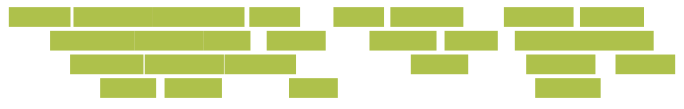

In [32]:
plt.rcParams["figure.figsize"] = (12,1.75)
plot_occupancy(blood_donor_chairs)

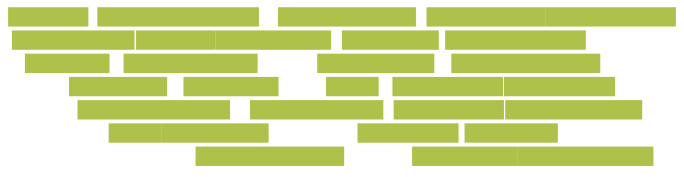

In [33]:
plt.rcParams["figure.figsize"] = (12,3)
plot_occupancy(plasma_donor_chairs)

In [37]:
blood_dataframe.describe()

,declaration,reception,preperation,check,clean
count,24.000000,24.000000,23.000000,23.000000,23.000000
mean,0.437402,0.260899,1.348187,0.053464,0.138979
std,0.813255,0.603005,3.422483,0.196299,0.332232
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.465803,0.000000,0.307691,0.000000,0.000000
max,2.427026,1.812668,12.974355,0.895396,1.203728


In [38]:
plasma_dataframe.describe()

,declaration,reception,preperation,check,clean
count,28.000000,28.000000,28.000000,28.000000,28.000000
mean,0.751768,0.075463,1.374310,0.140968,0.223576
std,1.127144,0.215002,3.079011,0.490424,0.551173
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.306943,0.000000,0.532592,0.000000,0.000000
max,3.941201,0.856203,11.789801,2.396416,1.777714
